In [ ]:
import pandas as pd
# read in trades data from GitHub
df = pd.read_csv('https://raw.githubusercontent.com/Cal-Poly-Quant-Club/data/main/trades.csv')

After importing your data, take a look at it to get an idea of what your dataset looks like.

In [ ]:
print(df.columns)
# Convert the timestamp to a datetime object
df['time'] = pd.to_datetime(df['time'])
# set as index
df.set_index('time', inplace=True)
df

Our main goal is to understand price fluctuations, so let's create a variable that holds these differences.

In [ ]:
df["price_change"] = df["price"].diff()
df["went_up?"] = df["price_change"].shift(-1) > 0
# save with index
df.to_csv('trades_with_price_change.csv')

In [ ]:
# Load with index
df = pd.read_csv('trades_with_price_change.csv', index_col='time')
df

,condition,trade_id,price,size,exchange_code,exchange,price_change,went_up?
time,,,,,,,,
2022-11-21 09:00:00.008365476,"['@', 'T', 'I']",1,150.7900,10,K,C,NaN,False
2022-11-21 09:00:00.009253036,"['@', 'T', 'I']",2,150.7200,1,K,C,-0.0700,False
2022-11-21 09:00:00.013375907,"['@', 'T', 'I']",3,150.7200,1,K,C,0.0000,True
2022-11-21 09:00:00.017078112,"['@', 'T', 'I']",4,150.7900,4,K,C,0.0700,False
2022-11-21 09:00:00.017440876,"['@', 'T', 'I']",5,150.7900,10,K,C,0.0000,False
...,...,...,...,...,...,...,...,...
2022-11-21 16:24:56.021472970,['@'],121622,148.4400,100,D,C,-0.0188,False
2022-11-21 16:24:56.026186281,"['@', 'I']",121623,148.4400,4,D,C,0.0000,True
2022-11-21 16:24:56.052555013,"['@', 'I']",121624,148.4588,1,D,C,0.0188,False


`.describe()` is a useful tool for learning more about the contents of a numerical column.

In [ ]:
# Analyze the size of the trades
df['size'].describe()

count    250000.000000
mean         95.294924
std        2390.839980
min           1.000000
25%           1.000000
50%          25.000000
75%         100.000000
max      615105.000000
Name: size, dtype: float64

<Axes: >

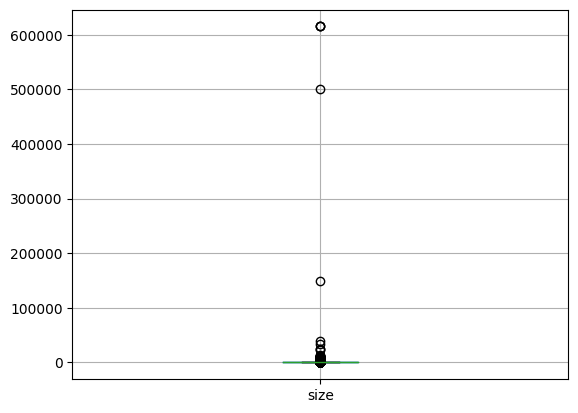

In [ ]:
# From the describe, it's clear we have some significant outliers, lets visualize this
df.boxplot('size')

<Axes: >

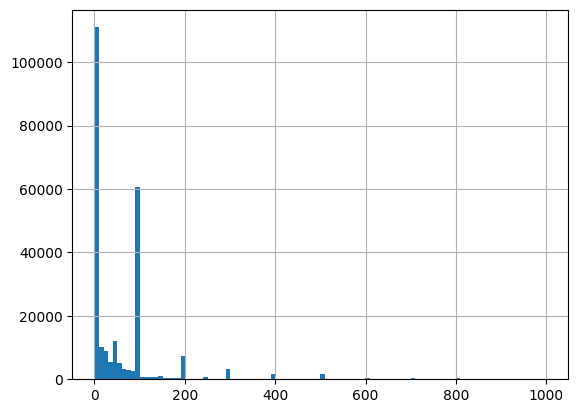

In [ ]:
# It looks like we have some significant outliers in the size of the trades. Let's plot the distribution of the trade sizes.
# Remove top 1% of trades
filtered_df = df[df['size'] < df['size'].quantile(0.99)]
filtered_df.boxplot("size")
# filtered_df['size'].hist(bins=100)

In [ ]:
# Looking better, although we will look at the outliers in more detail later
# For now, we can see there are some weird spikes in the data.
# Grab the top 20 most common trade sizes
filtered_df['size'].value_counts().head(20)
# We see that small trades are very common, along with multiples of 5, 10, and 100.
# Multiples of 100 play nice with options, as one contract corresponds to 100 shares.
# Multiples of 5 and 10 could be representative of human traders, who tend to trade in round numbers.

size
1      82895
100    57637
50      8638
200     6880
10      6591
2       5825
5       4204
3       3631
300     3046
20      2864
25      2857
4       2566
30      1682
500     1650
6       1510
400     1507
7       1483
40      1226
15      1222
9       1141
Name: count, dtype: int64

<Axes: xlabel='size'>

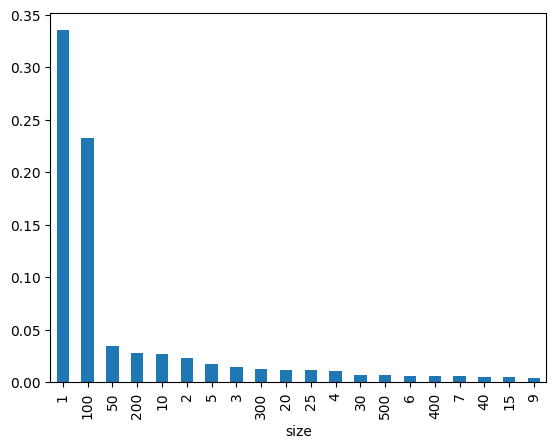

In [ ]:
# Let's look at the distribution of trade sizes for the top 20 most common trade sizes.
filtered_df["size"].value_counts(normalize=True).head(20).plot(kind='bar', stacked=True)
# There are almost the same number of trades of size 1, as there are of size 100.
# This is suprizing, as ~100x more money is being traded in the 100 size trades.
# This could be due to market makers, who to stay delta neutral need to buy/sell shares corresponding to the options they are selling.

size
1     82895
50     8638
10     6591
2      5825
5      4204
3      3631
20     2864
25     2857
4      2566
30     1682
6      1510
7      1483
40     1226
15     1222
9      1141
8      1119
12      960
11      932
14      824
16      800
Name: count, dtype: int64

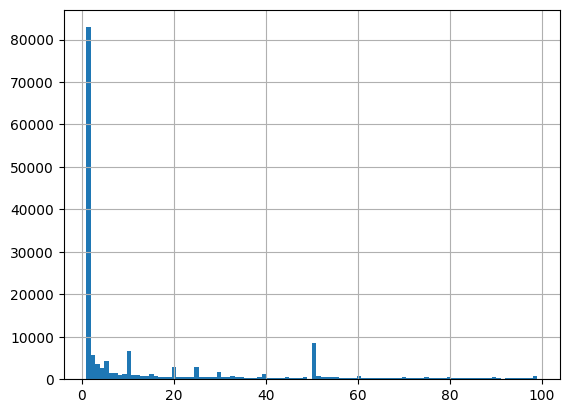

In [ ]:
# Lets focus now on trades < 100
filtered_df[filtered_df['size'] < 100]['size'].hist(bins=100)
# Print the top 20 most common trade sizes
filtered_df[filtered_df['size'] < 100]['size'].value_counts().head(20)
# Nothing seems out of the ordinary here, a dropoff corresponding to the size
# And again spikes at multiples of 5 or 10.

<Axes: >

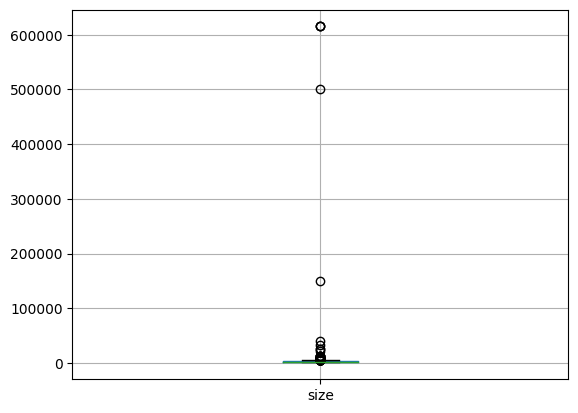

In [ ]:
# Now lets look at the outliers
outliers = df[df['size'] > df['size'].quantile(0.99)]
outliers.boxplot('size')
# It looks like there are outliers in our outliers...

In [ ]:
outliers["size"].describe()

count      1800.000000
mean       3842.981111
std       27896.780546
min        1001.000000
25%        1400.000000
50%        2000.000000
75%        2800.000000
max      615105.000000
Name: size, dtype: float64

In [ ]:
# Lets further filter the outliers
filtered_outliers = outliers[outliers['size'] < outliers['size'].quantile(0.99)]

<Axes: >

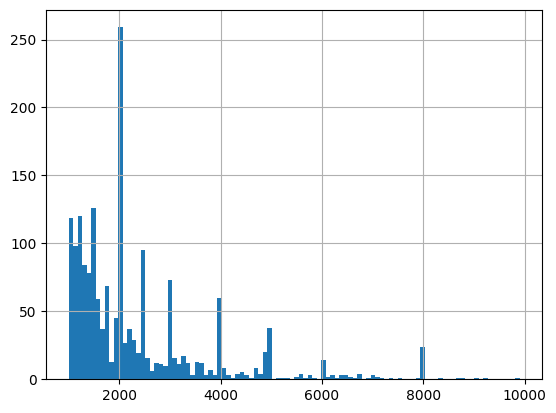

In [ ]:
# Histogram of the filtered outliers
filtered_outliers['size'].hist(bins=100)

In [ ]:
# Most common values
filtered_outliers['size'].value_counts().head(20)

size
2000    238
1500     96
1200     85
2500     84
3000     69
4000     56
1100     51
1400     50
1060     46
1800     45
1300     44
1600     28
5000     28
1700     25
8000     23
1900     20
4900     18
2100     13
2300     12
6000     12
Name: count, dtype: int64

In [ ]:
# Finally lets look at the outliers of the outliers
super_outliers = outliers[outliers['size'] > outliers['size'].quantile(0.99)]

<Axes: >

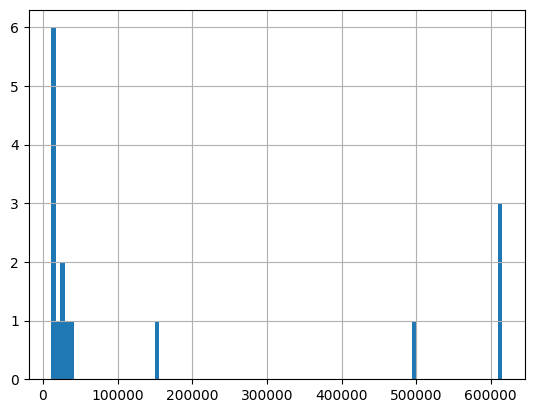

In [ ]:
# Histogram of the super outliers
super_outliers['size'].hist(bins=100)

In [ ]:
# Most common values
super_outliers['size'].value_counts().head(20)

size
615105    3
25000     2
13085     1
22202     1
10954     1
12505     1
500000    1
39351     1
12286     1
11947     1
150000    1
12116     1
33412     1
Name: count, dtype: int64

In [ ]:
# We see three traades of 5127604, which is odd..
# How much money is that?
big_trade = 5127604 * super_outliers['price'].mean()
big_trade
#760M USD, that's a lot of money for a single trade.
#How much of the overall volume is that?

763641244.71

In [ ]:
volume = df['size'].sum() * df['price'].mean()
volume

3551298684.3563557

In [ ]:
big_trade / volume

0.21503154552273426

In [ ]:
# What was the exchange code of the biggest trade?
biggest_trade = df[df['size'] == df['size'].max()]
biggest_trade['exchange_code']

time
2022-11-21 14:30:02.009813139    Q
2022-11-21 14:30:02.009813139    T
2022-11-21 14:30:02.010306112    Q
Name: exchange_code, dtype: object

<Axes: >

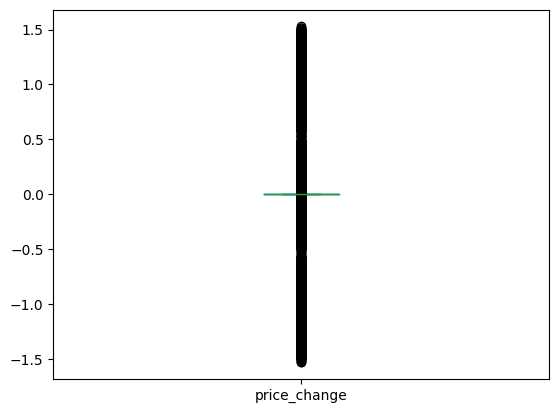

In [ ]:
# Lets go back to the original data, and look at the distribution of price changes
# Create a boxplot
df['price_change'].plot(kind='box')

<Axes: >

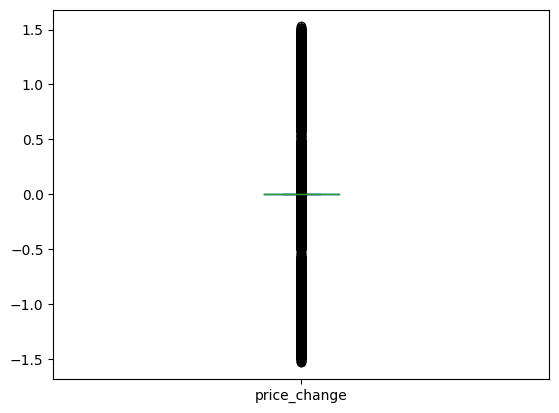

In [ ]:
#filtered_df['price_change'].hist(bins=100)
# We also have some outliers, lets filter them out using the IQR method
Q1 = filtered_df['price_change'].quantile(0.02)
Q3 = filtered_df['price_change'].quantile(0.98)
IQR = Q3 - Q1
filtered_df = filtered_df[(filtered_df['price_change'] > (Q1 - 1.5 * IQR)) & (filtered_df['price_change'] < (Q3 + 1.5 * IQR))]
# Boxplot
filtered_df['price_change'].plot(kind='box')
# Woah, the majority of the price change was positive

<Axes: >

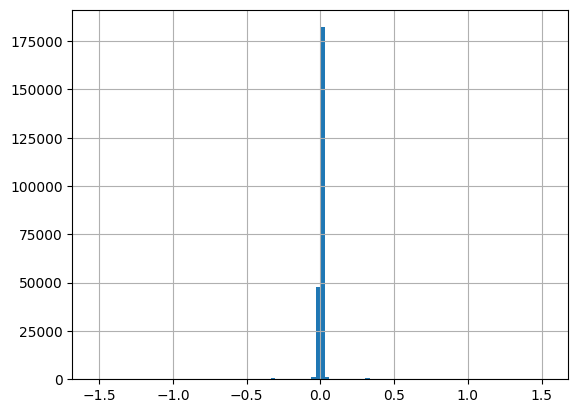

In [ ]:
filtered_df['price_change'].hist(bins=100)

<Axes: >

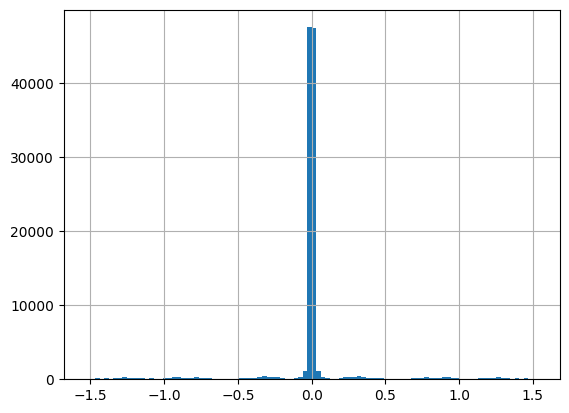

In [ ]:
# We have a lot of trades with a price change of 0, lets remove those
filtered_df = filtered_df[filtered_df['price_change'] != 0]
filtered_df['price_change'].hist(bins=100)

In [ ]:
# Much better, we also have some strange spikes, lets look at those
filtered_df['price_change'].value_counts(ascending=False).head(20)

price_change
-0.0100    6833
 0.0100    6618
-0.0050    5165
 0.0050    5062
-0.0100    3226
 0.0100    3073
 0.0088    1400
-0.0088    1349
-0.0001    1308
 0.0001    1272
 0.0050    1078
-0.0050    1060
 0.0012    1008
-0.0012     957
-0.0200     943
 0.0200     924
 0.0038     768
-0.0038     744
 0.0038     606
-0.0038     603
Name: count, dtype: int64

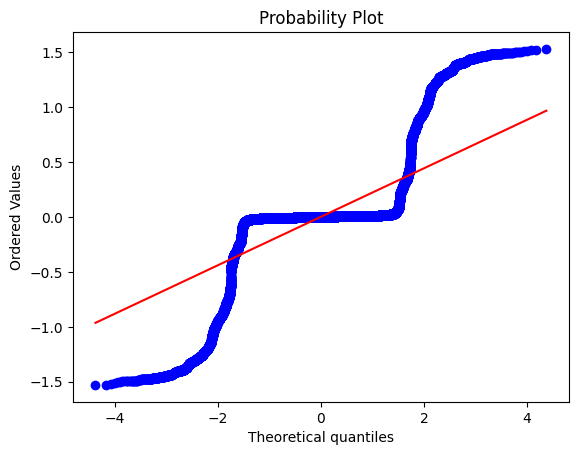

In [ ]:
# Lets test for normality with a QQ plot
import scipy.stats as stats
import matplotlib.pyplot as plt

stats.probplot(filtered_df['price_change'], dist="norm", plot=plt)
plt.show()


In [ ]:
# Very much not normal
import numpy as np
# Lets apply a transformation to make it more normal by taking the log of the price change
filtered_df['log_price_change'] = filtered_df['price_change'].apply(lambda x : x**0.000001)

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


((array([-4.37175642, -4.17409622, -4.06662705, ...,  4.06662705,
          4.17409622,  4.37175642]),
  array([0.99998618+3.14154925e-06j, 0.99998618+0.00000000e+00j,
         0.99998618+0.00000000e+00j, ..., 1.00000042+3.14159399e-06j,
         1.00000042+3.14159399e-06j, 1.00000042+0.00000000e+00j])),
 ((1.869169586189048e-06+6.908293101145817e-08j),
  (0.9999953776529115+1.5703840549337047e-06j),
  (0.7388989017200098+0.027309080047701415j)))

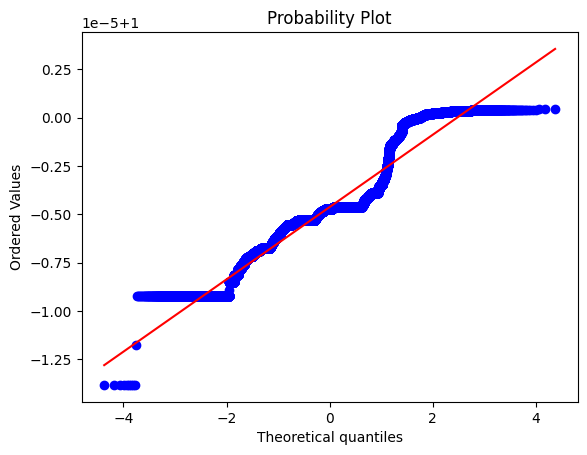

In [ ]:
# QQ plot
stats.probplot(filtered_df['log_price_change'], dist="norm", plot=plt)

This looks a bit better. Now let's see how trade sizes change throughout the day.

Corr_coef: 0.05262759892315276


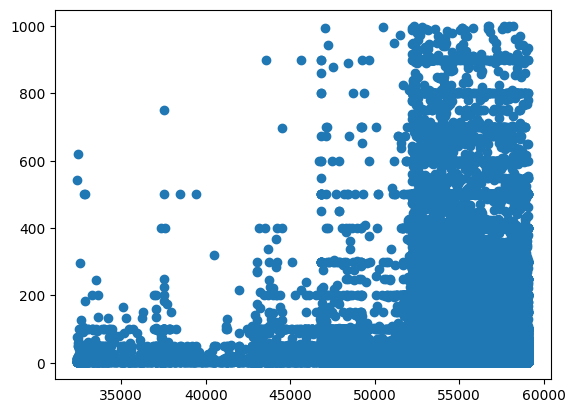

In [ ]:
from datetime import time
from scipy.stats import pearsonr
filtered_df["time"] = filtered_df.index
format = "%Y-%m-%d %H:%M:%S.%f"
filtered_df["purchase_time"] = pd.to_datetime(filtered_df["time"])
filtered_df["just_time"] = filtered_df["purchase_time"].dt.time
filtered_df["just_time"] = filtered_df["just_time"].apply(lambda x : int(x.strftime("%H:%M:%S")[:2]) * 3600 + int(x.strftime("%H:%M:%S")[3:5]) * 60 + int(x.strftime("%H:%M:%S")[6:]))
filtered_df["size"] = filtered_df["size"].apply(lambda x : int(x))
corr_coef = np.corrcoef(filtered_df["just_time"], filtered_df["size"])
print("Corr_coef: " + str(corr_coef[0,1]))
plt.scatter(filtered_df["just_time"], filtered_df["size"])
plt.show()

This wasn't very successful, as indicated by the very low correlation coefficient. Maybe aggregating our data by hour will help us extract some meaning.

3346346


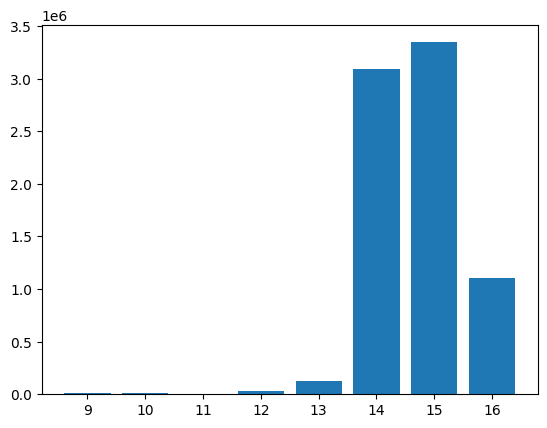

In [ ]:
import math
filtered_df["hour"] = filtered_df["just_time"].apply(lambda x : math.floor(x / 3600))
sale_by_hour = filtered_df.groupby(["hour"])
max_val = max(sale_by_hour["size"].sum())
#max_hour = [hour for hour in list(sale_by_hour.groups) if sale_by_hour.groups[hour]["size"].sum() == max_val]
print(max_val)
plt.bar(list(sale_by_hour.groups), sale_by_hour["size"].sum())
plt.show()

Let's break it down even further to look by the minute. Here, we can clearly see a few important times where a lot is happening.

225449


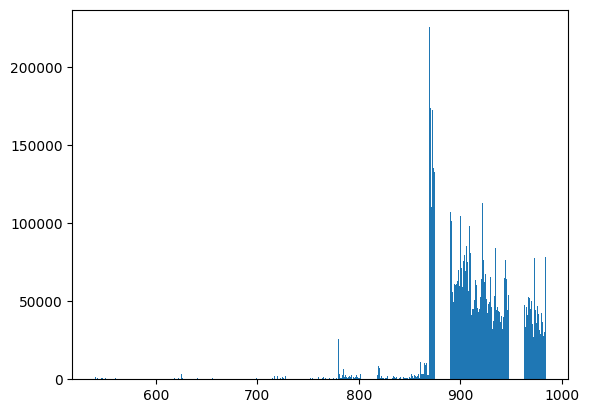

In [ ]:
filtered_df["minute"] = filtered_df["just_time"].apply(lambda x : math.floor(x / 60))
sale_by_min = filtered_df.groupby(["minute"])
max_val = max(sale_by_min["size"].sum())
print(max_val)
plt.bar(list(sale_by_min.groups), sale_by_min["size"].sum())
plt.show()